# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [124]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load data

In [4]:
#variables related to loading
path = "M06_th45/"
path_fields = "M06_th45/"
path_particles = "M06_th45/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
numframe = 2000


In [5]:
#load fields
dfields = dh5.field_loader(path=path_fields,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/data_h5.py:170: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [142]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, dfields['ex_xx'][0], dfields['ex_xx'][-1], dfields['ex_yy'][0], dfields['ex_yy'][10], dfields['ex_zz'][0], dfields['ex_zz'][10])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  125.1563630104065


In [143]:
dparticles

{'p1': array([-7.692928 , -1.6944066, -2.9531925, ..., -7.7446227, -8.021009 ,
        -8.4358225], dtype=float32),
 'p2': array([ 6.7776113 , -3.613516  , -4.1075463 , ...,  0.86105275,
         0.22804981,  0.23817924], dtype=float32),
 'p3': array([ 4.516578  , -0.55613947, -6.344814  , ..., -0.93958575,
         0.5901785 , -0.93769205], dtype=float32),
 'x1': array([24.20981 , 24.404867, 24.183159, ..., 71.862144, 71.96846 ,
        71.90031 ], dtype=float32),
 'x2': array([1.3047022, 1.1508163, 1.9824317, ..., 2.1328776, 2.173762 ,
        2.0149832], dtype=float32),
 'x3': array([0.6070007 , 1.2337017 , 1.2392945 , ..., 0.39299634, 0.73030424,
        0.44766763], dtype=float32)}

In [144]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

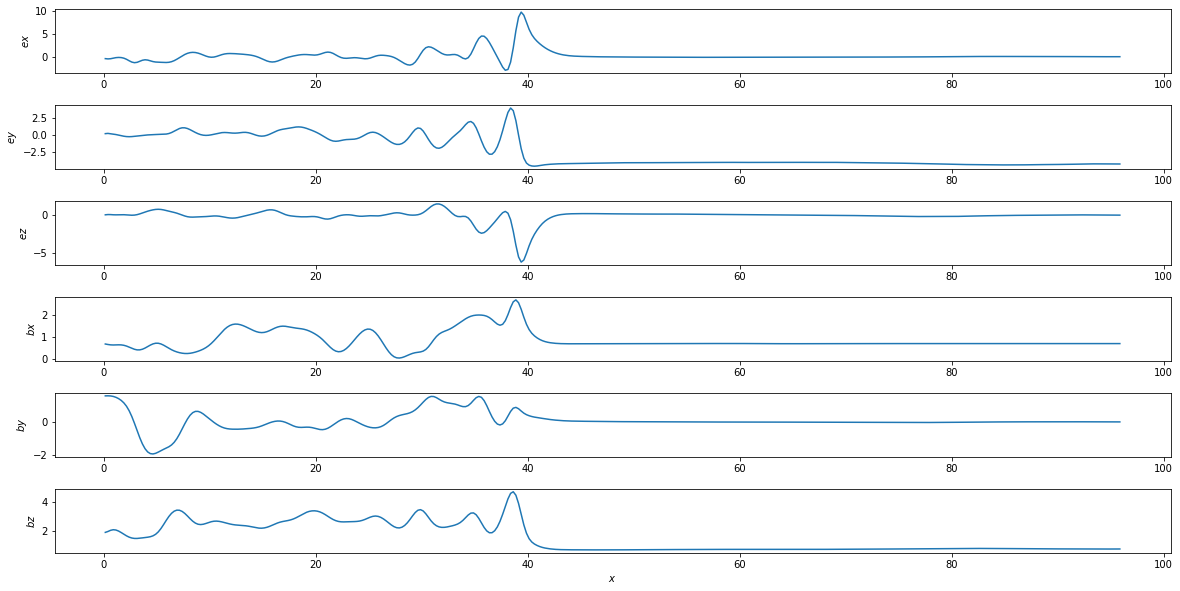

In [12]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

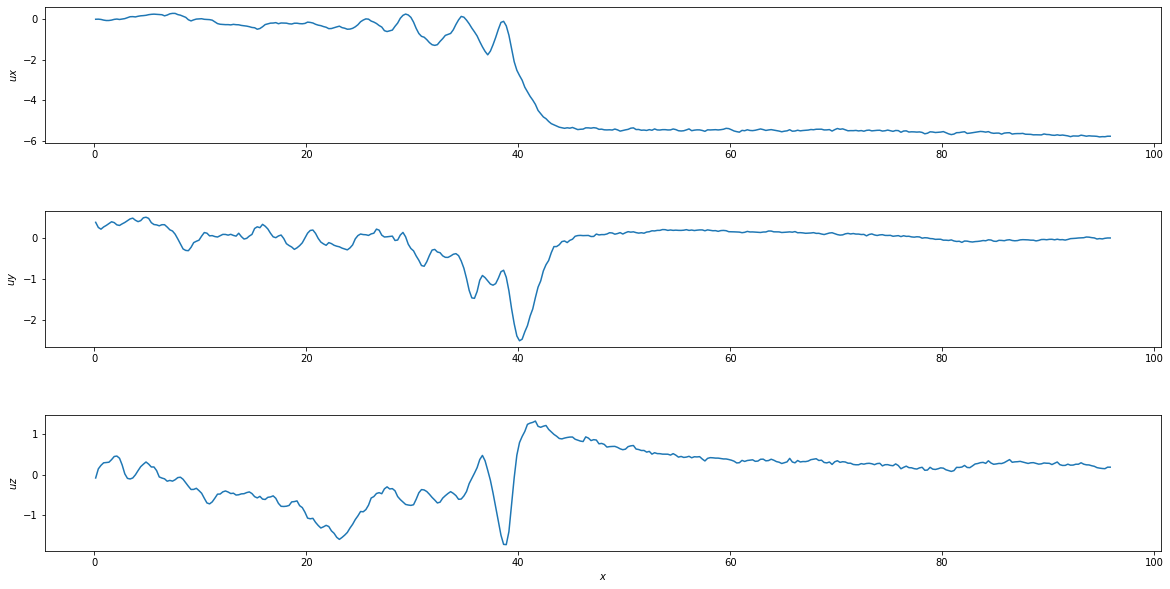

In [13]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

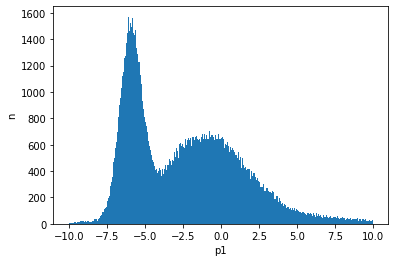

<Figure size 432x288 with 0 Axes>

In [15]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., dfields['ex_xx'][0], dfields['ex_xx'][-1],dfields['ex_yy'][0], dfields['ex_yy'][-1])

### Compute Shock Vel and Lorentz transform fields

In [19]:
#pick some point in the middle of the simulation and plot it as a function of time
all_dfields = dh5.all_dfield_loader(path=path_fields, verbose=False)


/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/data_h5.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [20]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


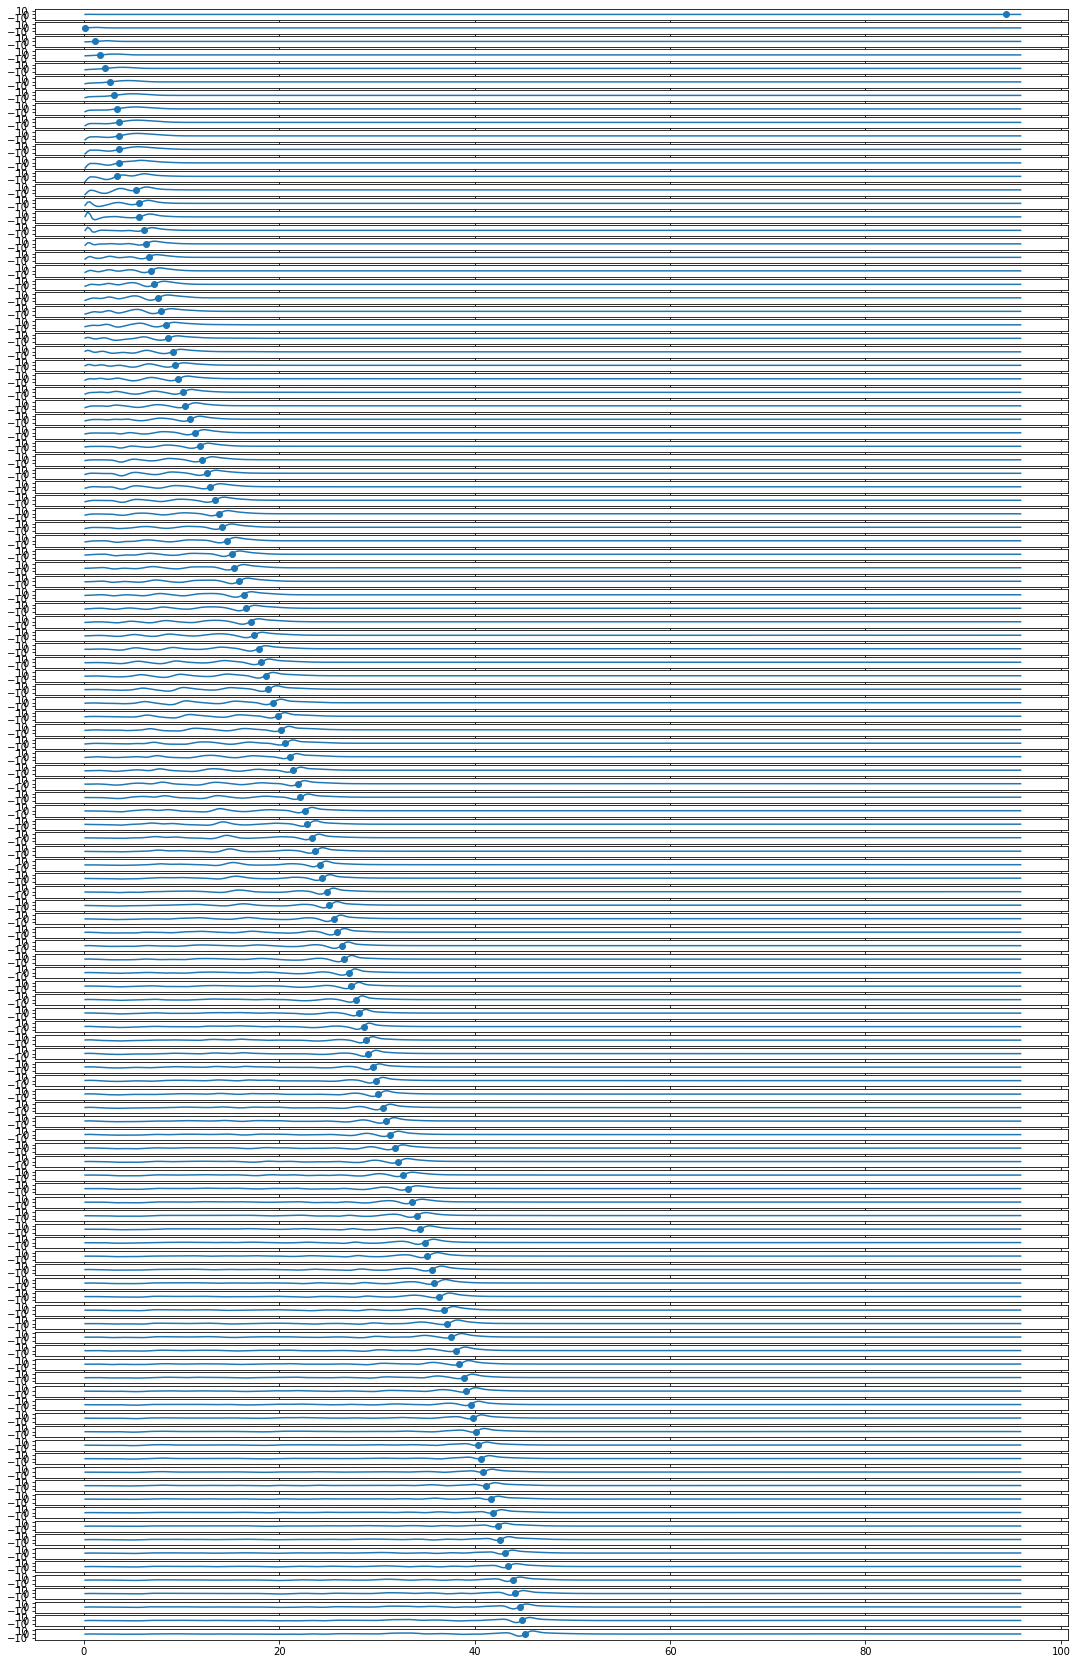

In [24]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [26]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

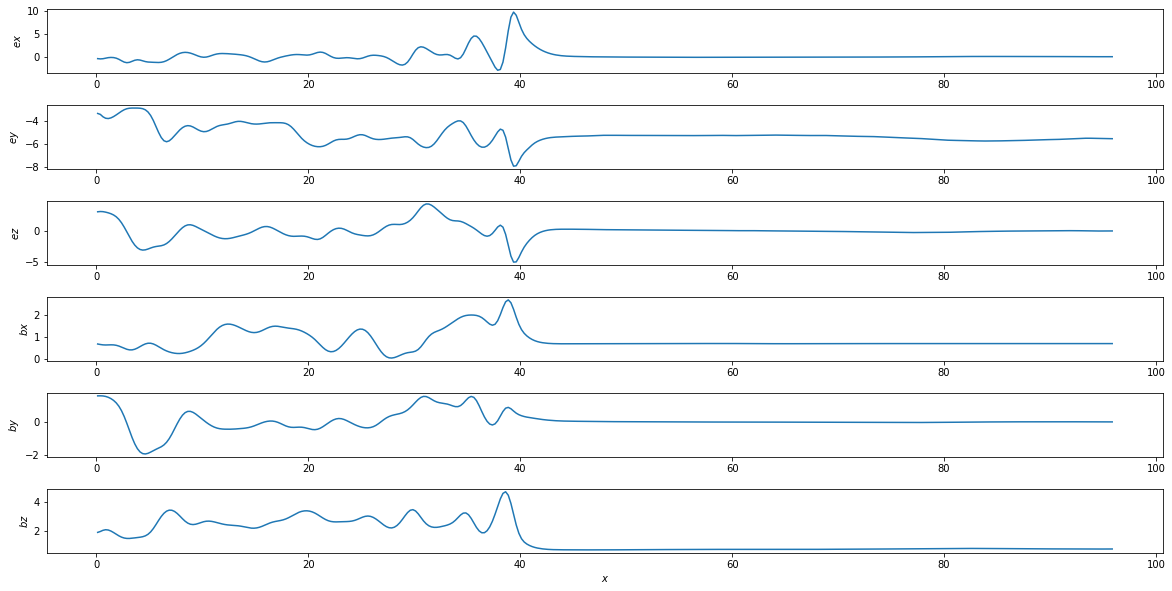

In [27]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

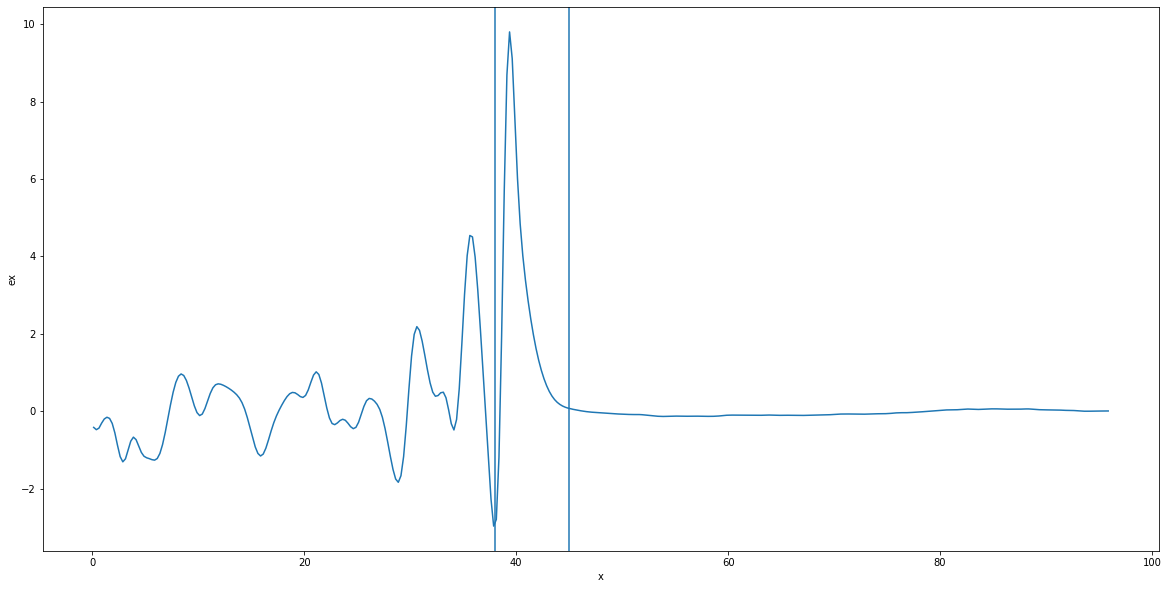

In [40]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 38.#lower bound for metadata = 1 (di)
endval = 45. #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [42]:
metadata = md.build_metadata(dfields, startval, endval)

In [43]:
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Test super plot

In [125]:
# x1 = 28.125
# x2 = 28.375
# y1 = 0.125
# y2 = .375
# z1 = 0.125
# z2 = .375
x1 = 15.125 
x2 = 16. 
y1 = 0.125 
y2 = 10.375 
z1 = 0.125 
z2 = 10.375
vmax = 15.
dv = .25

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [126]:
dfields['ex_yy']

array([ 0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,  1.875,
        2.125,  2.375,  2.625,  2.875,  3.125,  3.375,  3.625,  3.875,
        4.125,  4.375,  4.625,  4.875,  5.125,  5.375,  5.625,  5.875,
        6.125,  6.375,  6.625,  6.875,  7.125,  7.375,  7.625,  7.875,
        8.125,  8.375,  8.625,  8.875,  9.125,  9.375,  9.625,  9.875,
       10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875])

In [127]:
totalPtcl

0

In [128]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

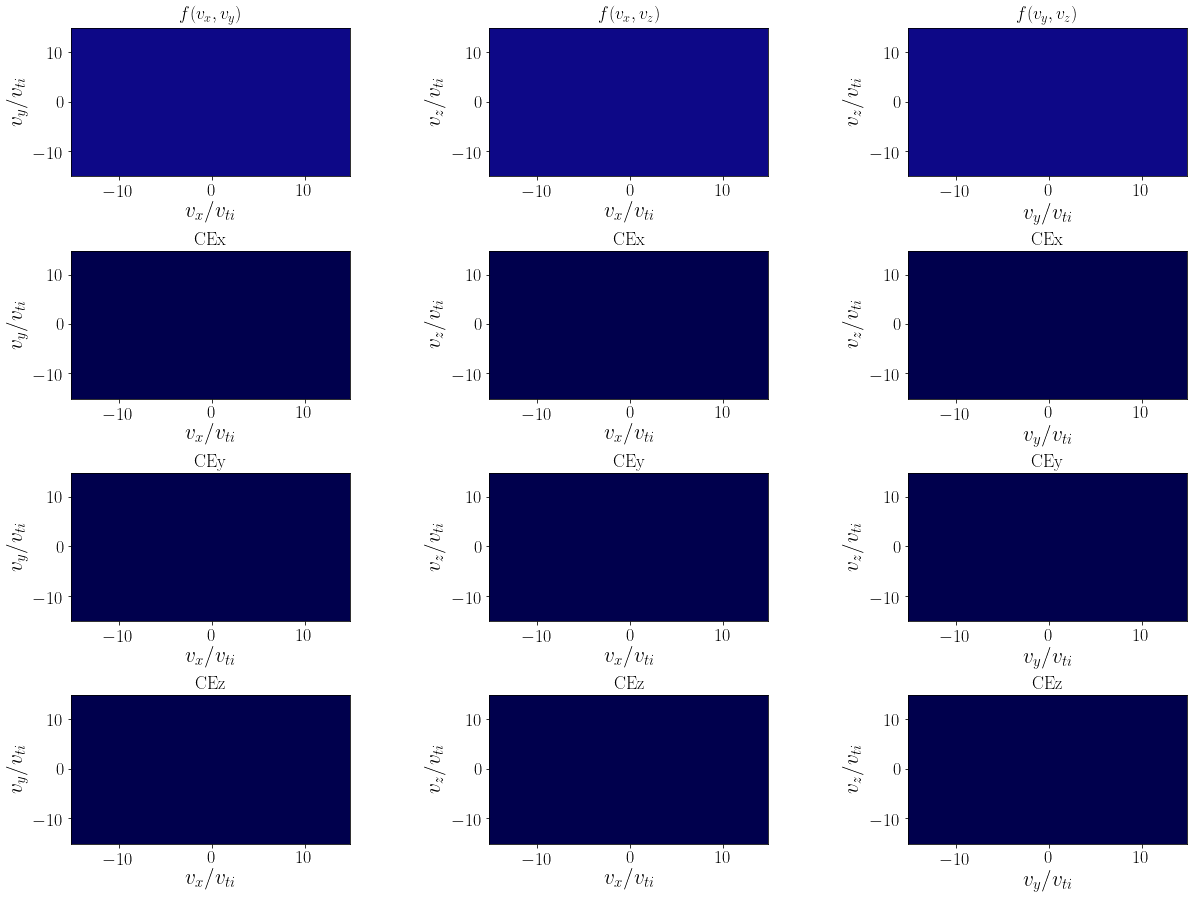

In [129]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [61]:
#Define parameters related to analysis
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0] #assumes rectangular grid thats uniform for all fields

In [75]:
dx

0.25

In [89]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock)

0.125 0.375 0.125 1.375 0.125 1.375
0
0.375 0.625 0.125 1.375 0.125 1.375
0


KeyboardInterrupt: 

In [71]:
CEx[100][100][100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

### Make superplot gif

In [63]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

Making plot 0 of 383
Making plot 1 of 383
Making plot 2 of 383
Making plot 3 of 383
Making plot 4 of 383
Making plot 5 of 383
Making plot 6 of 383
Making plot 7 of 383
Making plot 8 of 383
Making plot 9 of 383
Making plot 10 of 383
Making plot 11 of 383
Making plot 12 of 383
Making plot 13 of 383
Making plot 14 of 383
Making plot 15 of 383
Making plot 16 of 383
Making plot 17 of 383
Making plot 18 of 383
Making plot 19 of 383
Making plot 20 of 383
Making plot 21 of 383
Making plot 22 of 383
Making plot 23 of 383
Making plot 24 of 383
Making plot 25 of 383
Making plot 26 of 383
Making plot 27 of 383
Making plot 28 of 383
Making plot 29 of 383
Making plot 30 of 383
Making plot 31 of 383
Making plot 32 of 383
Making plot 33 of 383
Making plot 34 of 383
Making plot 35 of 383
Making plot 36 of 383
Making plot 37 of 383
Making plot 38 of 383
Making plot 39 of 383
Making plot 40 of 383
Making plot 41 of 383
Making plot 42 of 383
Making plot 43 of 383
Making plot 44 of 383
Making plot 45 of 38

KeyboardInterrupt: 

In [64]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

### Convert to previous '2v FPC' formatting

In [130]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_out = []
CEy_out = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEx_out.append(CEx_xy)
    CEy_out.append(CEy_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_out = vx_xy
vy_out = vy_xy
x_out = x

TypeError: object of type 'numpy.float64' has no len()

### Compute energization from correlations

In [ ]:
#TODO: project onto 2d plane and handle different projections net energization
enerCEx_out = anl.compute_energization_over_x(CEx_out,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_out,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [145]:
inputdict = dnc.parse_input_file(path)

FileNotFoundError: [Errno 2] No such file or directory: 'M06_th45/input/input'

In [ ]:
params = dnc.build_params(inputdict,numframe)

In [ ]:
inputdict

In [ ]:
params

In [146]:
flnm = 'dHybridRSDAtest1newformatwithE.nc'
try:
    dnc.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    dnc.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)

NameError: name 'vx_out' is not defined

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [ ]:
CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_out, 'ex', x_out, dx, dfields, 'CExFrame1000ExB', 'CExFrame1000ExB.gif')

<img src="CExFrame1000ExB.gif" width="750" align="center">

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_out, 'ey', x_out, dx, dfields, 'CEyFrame1000ExB', 'CEyFrame1000ExB.gif')

<img src="CEyFrame1000ExB.gif" width="750" align="center">

#### Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

##  Plot fields as a function of time

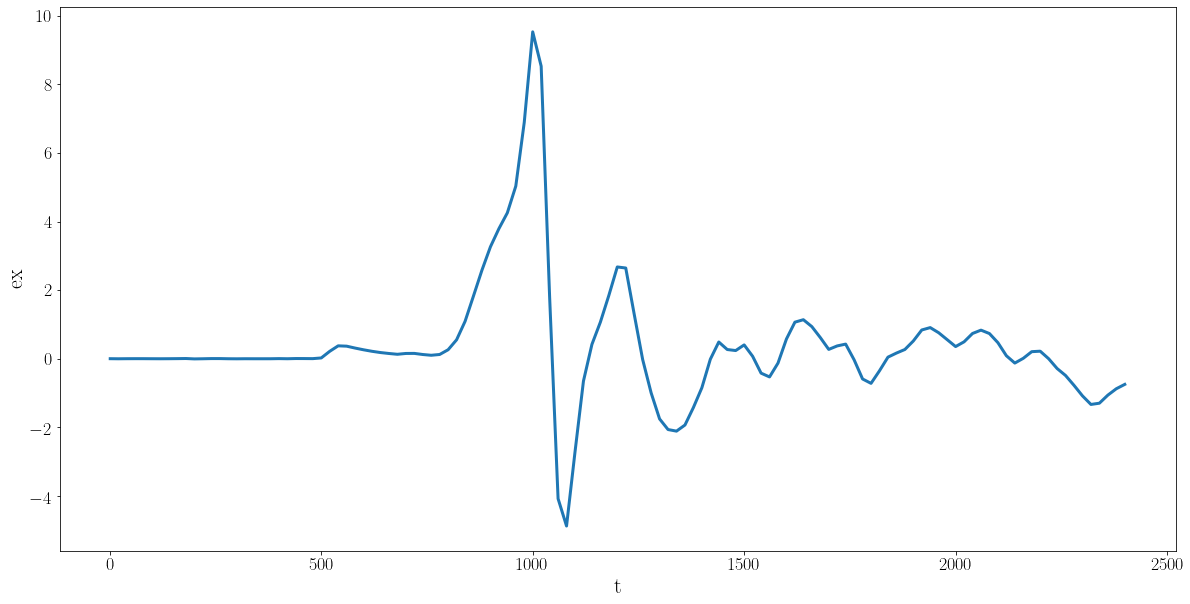

In [132]:
xxpltpoint = 20.0 #di
xxindex =  ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

## Test alternative get shock vel

In [133]:
ft.shockvel_from_compression_ratio(3)

//anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([1.5117404])

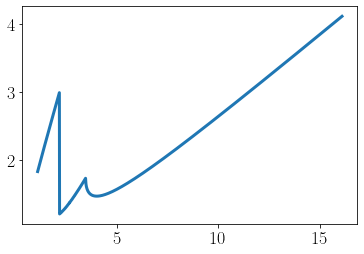

In [136]:
import matplotlib.pyplot as plt

dM = 0.01
M = 1.1
shockvelarray = []
Minputarray = []
for k in range(0,1500):
    shockvelarray.append(ft.shockvel_from_compression_ratio(M))
    Minputarray.append(M)
    M += dM
    
plt.figure()
plt.plot(Minputarray,shockvelarray)
plt.show()

In [137]:
def shock(M):
    gamma = 5./3.
    return lambda v: 8./3.*(M-v)**2./(2./3.*(M-v)**2+2.)-M/v

from scipy.optimize import fsolve
fsolve(shock(3),2.)

array([1.51366759])

In [138]:
temparr = [1,2,3]
temparr = np.asarray(temparr)
temparr

array([1, 2, 3])

In [139]:
temparr += 3

In [140]:
temparr

array([4, 5, 6])

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [141]:
anl.get_abs_max_velocity(dparticles)

(22.128841, 22.48681, 25.384571)

### Test making field pmesh

In [ ]:
xxindex = 164
plt2d.makefieldpmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
plt2d.makefieldpmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

### Test 2d fourier

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pltfr.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

### Estimate Ripple size

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

### Test version management

In [ ]:
##TODO: version management by saving git HEAD to netcdf4 file
#os.system('git rev-parse HEAD')

import subprocess

#https://stackoverflow.com/questions/34285796/python-execute-command-and-get-output
proc = subprocess.Popen(['git', 'rev-parse', 'HEAD'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(str(tmp)[2:-3]) #TODO: save this to netcdf4 file (edit save and load functions)